# Métricas



In [196]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    f1_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

sns.set()

Text(0.5, 1.0, 'Dataset')

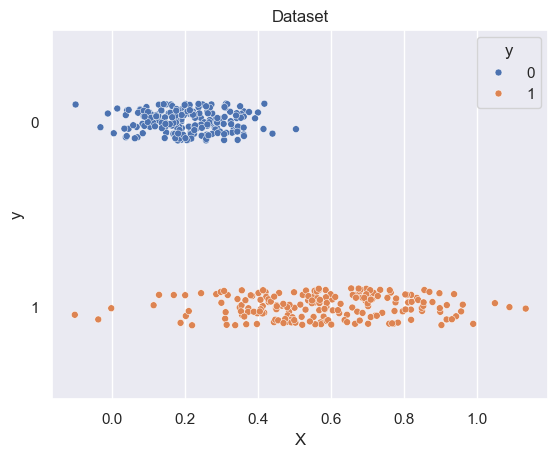

In [213]:
X = np.concatenate([
    np.random.normal(loc=0.2, scale=0.1, size=200),
    np.random.normal(loc=0.6, scale=0.22, size=200)
]).reshape(-1, 1)
y = np.concatenate([
    np.zeros(200, dtype=int),
    np.ones(200, dtype=int)
])

ax = sns.stripplot(
    data=pd.DataFrame({"X":X[:,0],"y":y}),
    x="X",y="y",
    hue="y",
    orient="h",
    edgecolor="w",
    linewidth=0.35
)
ax.set_title("Dataset")

In [214]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.5
)

In [215]:
clf = LogisticRegression().fit(X_train,y_train)
y_true = y_test
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]

## Matriz de confusión

Tabla para calcular métricas de clasificación. Esta tabla representa cúantos registros / muestras fueron clasificados correctamente como verdaderos y falsos, y cuántas muestras fueron clasificadas erróneamente. Esta tabla se puede generalizar a cualquier número de clases agregándolas en filas y columnas, donde la diagonal representará cuántas muestras fueron clasificadas correctamente y las demás celdas de la tabla representarán el número de muestras clasificadas erróneamente.

|                        | Verdadero (real)      | Falso (real)         |
| ---------------------- | --------------------- | -------------------- |
| Verdadero (predicción) | Verdaderos positivos  | Falsos positivos     |
| Falso (predicción)     | Falsos negativos      | Verdaderos negativos |

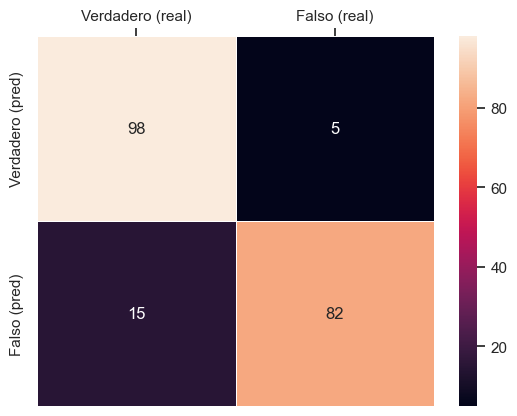

In [216]:
matriz_conf = pd.DataFrame(
    data=confusion_matrix(y_true, y_pred),
    index=["Verdadero (pred)", "Falso (pred)"],
    columns=["Verdadero (real)", "Falso (real)"]
)
ax = sns.heatmap(matriz_conf, annot=True, linewidth=.5)
ax.xaxis.tick_top()

### Sensitividad y Especificidad

**Caso 2 clases**

- Sensitividad: % de verdaderos (reales) que fueron correctamente identificados

$$
\frac{V_+}{V_++F_-}
$$

- Especificidad: % de falsos (reales) que fueron correctamente identificados

$$
\frac{V_-}{V_-+F_+}
$$

In [217]:
sensitividad  = matriz_conf.iloc[0,0] / (matriz_conf.iloc[0,0] + matriz_conf.iloc[1,0])
especificidad = matriz_conf.iloc[1,1] / (matriz_conf.iloc[0,1] + matriz_conf.iloc[1,1])
print(f"SEN: {sensitividad:.3f}\nESP: {especificidad:.3f}")

SEN: 0.867
ESP: 0.943


**Caso 3+ clases**

En este caso se obtienen valores de sensitividad y especificidad para cada clase. Se toman los valores de las clases diferentes a la que se quiere analizar (por ejemplo, clase **A**) y se juntan los datos como la clase temporal **no A**. Después, se calculan las métricas como en el caso de 2 clases.

### Precisión y Recall

- **Recall**: sensitividad

- **Precisión**: % de verdaderos (predicción) que clasifican correctamente a la muestra

$$
\frac{V_+}{V_++F_+}
$$

In [218]:
precision = matriz_conf.iloc[0,0] / (matriz_conf.iloc[0,0] + matriz_conf.iloc[0,1])
print(f"PRE: {precision:.3f}")

PRE: 0.951


### ROC y AUC

- **Receiver Operator Characteristic (ROC)**: Eje Y -> Sensitividad, Eje X -> 1 - Especificidad. Los puntos se obtienen al generar la matriz de confusión para múltiples umbrales de clasificación (cuando aplica). Se usa para comparar y encontrar el mejor umbral para un modelo en cuanto al balance de Sensitividad y 1 - Especificidad.

- **Area Under the Curve (AUC)**: Área debajo de la curva ROC, se usa para comparar dos o más modelos de clasificación de ML que usen umbrales de clasificación. $0 \leq AUC \leq 1$, y un valor mayor indica un mejor modelo. Esta métrica se puede interpretar como la capacidad del modelo para separar las clases una de otra.

Estas dos métricas son susceptibles al fallo cuando el conjunto de datos sufre de imbalance de clases. En ese caso es más recomendable usar la curva Precisión - Sensitividad (Precision - Recall curve).

(0.0, 1.0)

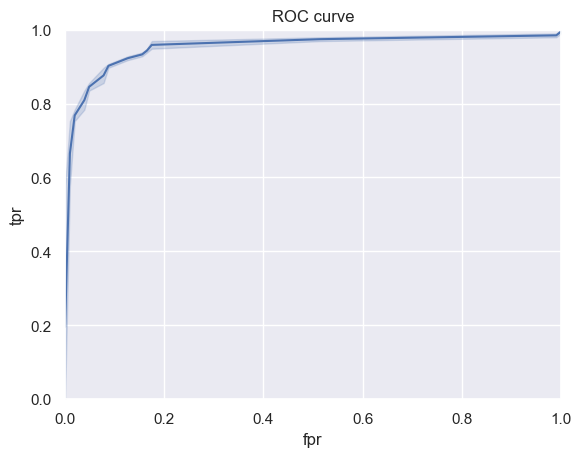

In [219]:
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
ax = sns.lineplot(pd.DataFrame({"fpr":fpr,"tpr":tpr}), x="fpr", y="tpr")
ax.set_title("ROC curve")
ax.set_xlim([0,1])
ax.set_ylim([0,1])

In [220]:
auc = roc_auc_score(y_true, y_prob)
print(f"AUC: {auc:.3f}")

AUC: 0.955


### Precision - Recall curve

Es una métrica del éxito en la predicción cuando existe imbalance de clases. Esta curva representa el *tradeoff* entre Precisión y Sensitividad / Recall para múltiples umbrales de clasificación. La precisión es una medida de la relevancia de las predicciones (proporción de predicciones positivas que son realmente positivas), mientras que la sensitividad es una medida de cuántos resultados positivos se detectan (clasifican como positivos).

(0.0, 1.0)

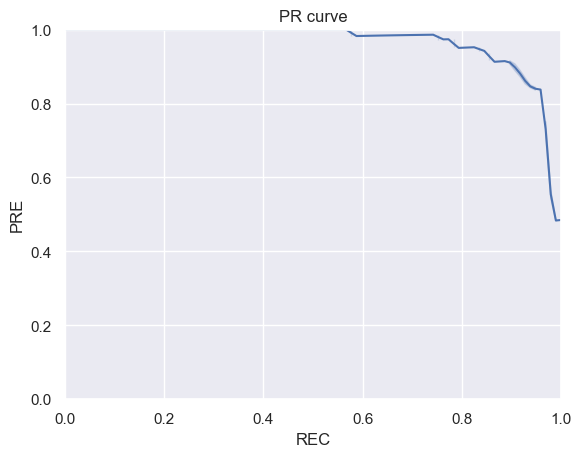

In [221]:
precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
ax = sns.lineplot(pd.DataFrame({"PRE":precision,"REC":recall}), x="REC", y="PRE")
ax.set_title("PR curve")
ax.set_xlim([0,1])
ax.set_ylim([0,1])

### F1 score

Es la media armónica entre la precisión y la sensitividad / recall, puede tener valores $0 \leq F_1 \leq 1$. Este valor alcanza su máximo cuando se encuentra el umbral que alcanza mejor balance entre precisión y sensitividad. Esta métrica es particularmente relevante en aplicaciones que se centran principalmente en la clase "positiva" y donde esta es rara en relación con la clase "negativa".

Text(0.5, 1.0, 'F1 curve')

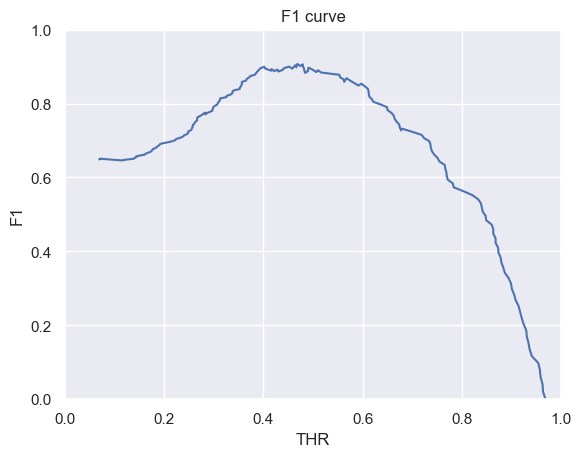

In [222]:
f1_scores = []

for threshold in thresholds:
    f1_scores.append(f1_score(y_true, y_prob>threshold)) #.astype(int)

ax = sns.lineplot(pd.DataFrame({"THR":thresholds,"F1":f1_scores}), x="THR", y="F1")
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_title("F1 curve")